## RL in iGibson

iGibson can be used with any learning framework that accommodates OpenAI gym interface. Feel free to use your favorite ones.

In this example, we show an environment wrapper of [TF-Agents](https://github.com/tensorflow/agents) for iGibson and an example training code for [SAC agent](https://arxiv.org/abs/1801.01290). The code can be found in [our fork of TF-Agents](https://github.com/StanfordVL/agents/): [agents/blob/igibson/tf_agents/environments/suite_gibson.py](https://github.com/StanfordVL/agents/blob/igibson/tf_agents/environments/suite_gibson.py), [train_eval.py](https://github.com/StanfordVL/agents/blob/cvpr21_challenge_tf2.4/tf_agents/agents/sac/examples/v2/train_eval.py), and [train_minival.sh](https://github.com/StanfordVL/agents/blob/cvpr21_challenge_tf2.4/tf_agents/agents/sac/examples/v2/train_minival.sh).


In [1]:
import numpy as np
from IPython import embed
import collections
import os

import tensorflow as tf

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import normal_projection_network
from tf_agents.networks.utils import mlp_layers
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_policy
from tf_agents.utils import common
from tf_agents.trajectories.time_step import TimeStep
from tensorflow.python.framework.tensor_spec import TensorSpec, BoundedTensorSpec

IMG_WIDTH = 160
IMG_HEIGHT = 120
SCAN_DIM = 228
TASK_OBS_DIM = 4


class SACAgent:
    def __init__(
            self,
            root_dir,
            conv_1d_layer_params=[(32, 8, 4), (64, 4, 2), (64, 3, 1)],
            conv_2d_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 2)],
            encoder_fc_layers=[256],
            actor_fc_layers=[256],
            critic_obs_fc_layers=[256],
            critic_action_fc_layers=[256],
            critic_joint_fc_layers=[256],
            # Params for target update
            target_update_tau=0.005,
            target_update_period=1,
            # Params for train
            actor_learning_rate=3e-4,
            critic_learning_rate=3e-4,
            alpha_learning_rate=3e-4,
            td_errors_loss_fn=tf.compat.v1.losses.mean_squared_error,
            gamma=0.99,
            reward_scale_factor=1.0,
            gradient_clipping=None,
            # Params for eval
            eval_deterministic=False,
            # Params for summaries and logging
            debug_summaries=False,
            summarize_grads_and_vars=False
    ):
        '''A simple train and eval for SAC.'''

        root_dir = os.path.expanduser(root_dir)
        policy_dir = os.path.join(root_dir, 'train', 'policy')

        time_step_spec = TimeStep(
            TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
            TensorSpec(shape=(), dtype=tf.float32, name='reward'),
            BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount',
                              minimum=np.array(0., dtype=np.float32), maximum=np.array(1., dtype=np.float32)),
            collections.OrderedDict({
                'task_obs': BoundedTensorSpec(shape=(TASK_OBS_DIM,), dtype=tf.float32, name=None,
                                            minimum=np.array(-3.4028235e+38, dtype=np.float32),
                                            maximum=np.array(3.4028235e+38, dtype=np.float32)),
                'depth': BoundedTensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 1), dtype=tf.float32, name=None,
                                           minimum=np.array(0.0, dtype=np.float32),
                                           maximum=np.array(1.0, dtype=np.float32)),
                'rgb': BoundedTensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32, name=None,
                                         minimum=np.array(0.0, dtype=np.float32),
                                         maximum=np.array(1.0, dtype=np.float32)),
                'scan': BoundedTensorSpec(shape=(SCAN_DIM, 1), dtype=tf.float32, name=None,
                         minimum=np.array(0.0, dtype=np.float32),
                         maximum=np.array(1.0, dtype=np.float32)),
            })
        )
        observation_spec = time_step_spec.observation
        action_spec = BoundedTensorSpec(shape=(2,), dtype=tf.float32, name=None,
                                        minimum=np.array(-1.0, dtype=np.float32),
                                        maximum=np.array(1.0, dtype=np.float32))

        glorot_uniform_initializer = tf.compat.v1.keras.initializers.glorot_uniform()
        preprocessing_layers = {}
        if 'rgb' in observation_spec:
            preprocessing_layers['rgb'] = tf.keras.Sequential(mlp_layers(
                conv_1d_layer_params=None,
                conv_2d_layer_params=conv_2d_layer_params,
                fc_layer_params=encoder_fc_layers,
                kernel_initializer=glorot_uniform_initializer,
            ))

        if 'depth' in observation_spec:
            preprocessing_layers['depth'] = tf.keras.Sequential(mlp_layers(
                conv_1d_layer_params=None,
                conv_2d_layer_params=conv_2d_layer_params,
                fc_layer_params=encoder_fc_layers,
                kernel_initializer=glorot_uniform_initializer,
            ))

        if 'task_obs' in observation_spec:
            preprocessing_layers['task_obs'] = tf.keras.Sequential(mlp_layers(
                conv_1d_layer_params=None,
                conv_2d_layer_params=None,
                fc_layer_params=encoder_fc_layers,
                kernel_initializer=glorot_uniform_initializer,
            ))

        if 'scan' in observation_spec:
            preprocessing_layers['scan'] = tf.keras.Sequential(mlp_layers(
                conv_1d_layer_params=conv_1d_layer_params,
                conv_2d_layer_params=None,
                fc_layer_params=encoder_fc_layers,
                kernel_initializer=glorot_uniform_initializer,
            ))

        if len(preprocessing_layers) <= 1:
            preprocessing_combiner = None
        else:
            preprocessing_combiner = tf.keras.layers.Concatenate(axis=-1)

        actor_net = actor_distribution_network.ActorDistributionNetwork(
            observation_spec,
            action_spec,
            preprocessing_layers=preprocessing_layers,
            preprocessing_combiner=preprocessing_combiner,
            fc_layer_params=actor_fc_layers,
            continuous_projection_net=tanh_normal_projection_network.TanhNormalProjectionNetwork,
            kernel_initializer=glorot_uniform_initializer,
        )

        critic_net = critic_network.CriticNetwork(
            (observation_spec, action_spec),
            preprocessing_layers=preprocessing_layers,
            preprocessing_combiner=preprocessing_combiner,
            observation_fc_layer_params=critic_obs_fc_layers,
            action_fc_layer_params=critic_action_fc_layers,
            joint_fc_layer_params=critic_joint_fc_layers,
            kernel_initializer=glorot_uniform_initializer,
        )

        global_step = tf.compat.v1.train.get_or_create_global_step()
        tf_agent = sac_agent.SacAgent(
            time_step_spec,
            action_spec,
            actor_network=actor_net,
            critic_network=critic_net,
            actor_optimizer=tf.compat.v1.train.AdamOptimizer(
                learning_rate=actor_learning_rate),
            critic_optimizer=tf.compat.v1.train.AdamOptimizer(
                learning_rate=critic_learning_rate),
            alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
                learning_rate=alpha_learning_rate),
            target_update_tau=target_update_tau,
            target_update_period=target_update_period,
            td_errors_loss_fn=td_errors_loss_fn,
            gamma=gamma,
            reward_scale_factor=reward_scale_factor,
            gradient_clipping=gradient_clipping,
            debug_summaries=debug_summaries,
            summarize_grads_and_vars=summarize_grads_and_vars,
            train_step_counter=global_step)
        tf_agent.initialize()

        if eval_deterministic:
            self.eval_py_policy = greedy_policy.GreedyPolicy(tf_agent.policy)
        else:
            self.eval_py_policy = tf_agent.policy

        policy_checkpointer = common.Checkpointer(
            ckpt_dir=policy_dir,
            policy=tf_agent.policy,
            global_step=global_step)

        policy_checkpointer.initialize_or_restore()

        # activate the session
        obs = {
            'depth': np.ones((IMG_HEIGHT, IMG_WIDTH, 1)),
            'rgb': np.ones((IMG_HEIGHT, IMG_WIDTH, 3)),
            'task_obs': np.ones((TASK_OBS_DIM,)),
            'scan': np.ones((SCAN_DIM, 1)),
        }
        action = self.act(obs)
        print('activate TF session')
        print('action', action)

    def reset():
        pass

    def act(self, obs):
        batch_obs = {}
        for key in obs:
            batch_obs[key] = obs[key].astype(np.float32)
        time_step = TimeStep(
            np.ones(1),
            np.ones(1),
            np.ones(1),
            batch_obs,
        )
        policy_state = ()

        action_step = self.eval_py_policy.action(time_step, policy_state)
        action = action_step.action
        return action

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
agent = SACAgent(root_dir='/opt/ckpt')

activate TF session
action tf.Tensor([0.028295   0.99084055], shape=(2,), dtype=float32)


In [3]:
import gibson2
from gibson2.envs.igibson_env import iGibsonEnv
import logging

config_filename = os.path.join(gibson2.example_config_path, 'turtlebot_point_nav.yaml')
env = iGibsonEnv(config_file=config_filename, mode='headless')

INFO:root:Importing iGibson (gibson2 module)
INFO:root:Assets path: /opt/igibson/gibson2/data/assets
INFO:root:Gibson Dataset path: /opt/igibson/gibson2/data/g_dataset
INFO:root:iG Dataset path: /opt/igibson/gibson2/data/ig_dataset
INFO:root:3D-FRONT Dataset path: /opt/igibson/gibson2/data/threedfront_dataset
INFO:root:CubiCasa5K Dataset path: /opt/igibson/gibson2/data/cubicasa_dataset
INFO:root:Example path: /opt/igibson/gibson2/examples
INFO:root:Example config path: /opt/igibson/gibson2/examples/configs


torch is not available, falling back to rendering to memory(instead of tensor)


INFO:root:Device 0 is available for rendering
INFO:root:Using device 0 for rendering
INFO:root:IndoorScene model: Rs_int
INFO:root:StaticIndoorScene scene: Rs_int
INFO:root:Category walls
INFO:root:Model Rs_int
INFO:root:Loading the following URDF template /opt/igibson/gibson2/data/ig_dataset/scenes/Rs_int/urdf/Rs_int_walls.urdf
INFO:root:Scale: [1. 1. 1.]
INFO:root:Number of splits: 1
INFO:root:Instantiating scene into the following urdfs:
INFO:root:/opt/igibson/gibson2/data/ig_dataset/scene_instances/20210407-064006_15714765483961653148_18/walls_0.urdf
INFO:root:Category floors
INFO:root:Model Rs_int
INFO:root:Loading the following URDF template /opt/igibson/gibson2/data/ig_dataset/scenes/Rs_int/urdf/Rs_int_floors.urdf
INFO:root:Scale: [1. 1. 1.]
INFO:root:Number of splits: 1
INFO:root:Instantiating scene into the following urdfs:
INFO:root:/opt/igibson/gibson2/data/ig_dataset/scene_instances/20210407-064006_15714765483961653148_18/floors_0.urdf
INFO:root:Category ceilings
INFO:root:

******************PyBullet Logging Information:
PyBullet Logging Information******************


INFO:root:Number of splits: 1
INFO:root:Instantiating scene into the following urdfs:
INFO:root:/opt/igibson/gibson2/data/ig_dataset/scene_instances/20210407-064006_15714765483961653148_18/stool_4_0.urdf
INFO:root:Category coffee_table
INFO:root:Model 19740
INFO:root:Loading the following URDF template /opt/igibson/gibson2/data/ig_dataset/objects/coffee_table/19740/19740.urdf
INFO:root:Scale: [0.62430883 0.71229165 0.57655435]
INFO:root:Number of splits: 1
INFO:root:Instantiating scene into the following urdfs:
INFO:root:/opt/igibson/gibson2/data/ig_dataset/scene_instances/20210407-064006_15714765483961653148_18/coffee_table_5_0.urdf
INFO:root:Category plant
INFO:root:Model 3ac8ac4f319e5c0c785f06f424b9d06
INFO:root:Loading the following URDF template /opt/igibson/gibson2/data/ig_dataset/objects/plant/3ac8ac4f319e5c0c785f06f424b9d06/3ac8ac4f319e5c0c785f06f424b9d06.urdf
INFO:root:Scale: [0.7624165  0.67366927 0.25672776]
INFO:root:Number of splits: 1
INFO:root:Instantiating scene into th

INFO:root:/opt/igibson/gibson2/data/ig_dataset/scene_instances/20210407-064006_15714765483961653148_18/shelf_21_0.urdf
INFO:root:Category table_lamp
INFO:root:Model 14127
INFO:root:Loading the following URDF template /opt/igibson/gibson2/data/ig_dataset/objects/table_lamp/14127/14127.urdf
INFO:root:Scale: [0.25004532 0.2125449  0.25264009]
INFO:root:Number of splits: 1
INFO:root:Instantiating scene into the following urdfs:
INFO:root:/opt/igibson/gibson2/data/ig_dataset/scene_instances/20210407-064006_15714765483961653148_18/table_lamp_22_0.urdf
INFO:root:Category chair
INFO:root:Model 28a0b2a5afc96922ba63bc389be1ed5a
INFO:root:Loading the following URDF template /opt/igibson/gibson2/data/ig_dataset/objects/chair/28a0b2a5afc96922ba63bc389be1ed5a/28a0b2a5afc96922ba63bc389be1ed5a.urdf
INFO:root:Scale: [1.2165891  1.22180548 1.16866977]
INFO:root:Number of splits: 1
INFO:root:Instantiating scene into the following urdfs:
INFO:root:/opt/igibson/gibson2/data/ig_dataset/scene_instances/20210

INFO:root:Category bottom_cabinet
INFO:root:Model 49140
INFO:root:Loading the following URDF template /opt/igibson/gibson2/data/ig_dataset/objects/bottom_cabinet/49140/49140.urdf
INFO:root:Scale: [0.98414487 0.45077097 0.60381706]
INFO:root:Number of splits: 1
INFO:root:Instantiating scene into the following urdfs:
INFO:root:/opt/igibson/gibson2/data/ig_dataset/scene_instances/20210407-064006_15714765483961653148_18/bottom_cabinet_39_0.urdf
INFO:root:Category fridge
INFO:root:Model 11712
INFO:root:Loading the following URDF template /opt/igibson/gibson2/data/ig_dataset/objects/fridge/11712/11712.urdf
INFO:root:Scale: [1.19486447 1.00482574 0.85822393]
INFO:root:Number of splits: 1
INFO:root:Instantiating scene into the following urdfs:
INFO:root:/opt/igibson/gibson2/data/ig_dataset/scene_instances/20210407-064006_15714765483961653148_18/fridge_40_0.urdf
INFO:root:Category bottom_cabinet
INFO:root:Model 46380
INFO:root:Loading the following URDF template /opt/igibson/gibson2/data/ig_dat

INFO:root:Moving URDF to (pos,ori): [0. 0. 0.], [0. 0. 0. 1.]
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/scene_instances/20210407-064006_15714765483961653148_18/floors_0.urdf
INFO:root:Moving URDF to (pos,ori): [0. 0. 0.], [0. 0. 0. 1.]
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/scene_instances/20210407-064006_15714765483961653148_18/ceilings_0.urdf
INFO:root:Moving URDF to (pos,ori): [0. 0. 0.], [0. 0. 0. 1.]
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/scene_instances/20210407-064006_15714765483961653148_18/bottom_cabinet_0_0.urdf
INFO:root:Moving URDF to (pos,ori): [-1.78945398 -0.50183213  0.36946967], [0.         0.         0.71240277 0.70177083]
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/scene_instances/20210407-064006_15714765483961653148_18/plant_1_0.urdf
INFO:root:Moving URDF to (pos,ori): [-1.80831023 -0.51558935  1.0704797 ], [0.         0.         0.71148495 0.70270134]
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/scen

INFO:root:Moving URDF to (pos,ori): [0. 0. 0.], [0. 0. 0. 1.]
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/scene_instances/20210407-064006_15714765483961653148_18/shower_31_0.urdf
INFO:root:Moving URDF to (pos,ori): [0. 0. 0.], [0. 0. 0. 1.]
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/scene_instances/20210407-064006_15714765483961653148_18/towel_rack_32_0.urdf
INFO:root:Moving URDF to (pos,ori): [0. 0. 0.], [0. 0. 0. 1.]
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/scene_instances/20210407-064006_15714765483961653148_18/towel_rack_33_0.urdf
INFO:root:Moving URDF to (pos,ori): [0. 0. 0.], [0. 0. 0. 1.]
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/scene_instances/20210407-064006_15714765483961653148_18/carpet_34_0.urdf
INFO:root:Moving URDF to (pos,ori): [0. 0. 0.], [0. 0. 0. 1.]
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/scene_instances/20210407-064006_15714765483961653148_18/sink_35_0.urdf
INFO:root:Moving URDF to (pos,ori): [0. 0. 0

INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/floor_lamp/c7aadb7ac29ac778aaae3d020f5ddf8/shape/visual/c7aadb7ac29ac778aaae3d020f5ddf8_m3_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/floor_lamp/c7aadb7ac29ac778aaae3d020f5ddf8/shape/visual/c7aadb7ac29ac778aaae3d020f5ddf8_m1_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/stool/ottoman/shape/visual/ottoman_m1_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/stool/ottoman/shape/visual/ottoman_m2_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/coffee_table/19740/shape/visual/link_8_m1_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/coffee_table/19740/shape/visual/link_8_m2_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/coffee_table/19740/shape/visual/link_0_m2_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/coffee_table/19740/shape/visual/link_1_m2_vm.obj
INFO:root:Load

INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/table/72c8fb162c90a716dc6d75c6559b82a2/shape/visual/72c8fb162c90a716dc6d75c6559b82a2_m1_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/table/72c8fb162c90a716dc6d75c6559b82a2/shape/visual/72c8fb162c90a716dc6d75c6559b82a2_m2_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/shelf/de3b28f255111570bc6a557844fbbce9/shape/visual/de3b28f255111570bc6a557844fbbce9_m1_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/shelf/de3b28f255111570bc6a557844fbbce9/shape/visual/de3b28f255111570bc6a557844fbbce9_m1_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/shelf/b7697d284c38fcade76bc197b3a3ffc0/shape/visual/b7697d284c38fcade76bc197b3a3ffc0_m2_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/shelf/b7697d284c38fcade76bc197b3a3ffc0/shape/visual/b7697d284c38fcade76bc197b3a3ffc0_m1_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_datas

INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/microwave/7265/shape/visual/link_13_m1_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/microwave/7265/shape/visual/link_14_m1_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/microwave/7265/shape/visual/link_15_m1_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/microwave/7265/shape/visual/link_16_m1_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/microwave/7265/shape/visual/link_17_m1_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/microwave/7265/shape/visual/link_18_m1_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/microwave/7265/shape/visual/link_19_m5_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/dishwasher/12085/shape/visual/link_0_m1_vm.obj
INFO:root:Loading /opt/igibson/gibson2/data/ig_dataset/objects/dishwasher/12085/shape/visual/link_1_m4_vm.obj
INFO:root:Loading

In [4]:
state_hist = []
reward_hist = []
done_hist = []
info_hist = []
state = env.reset()
for i in range(500):
    print(i)
    action = agent.act(state).numpy()
    state, reward, done, info = env.step(action)
    state_hist.append(state)
    reward_hist.append(reward)
    done_hist.append(done)
    info_hist.append(info)
    if done:
        logging.info(
            "Episode finished after {} timesteps".format(i + 1))
        break

INFO:root:Resetting URDF to (pos,ori): [0. 0. 0.], [0. 0. 0. 1.]
INFO:root:Resetting URDF to (pos,ori): [0. 0. 0.], [0. 0. 0. 1.]
INFO:root:Resetting URDF to (pos,ori): [0. 0. 0.], [0. 0. 0. 1.]
INFO:root:Resetting URDF to (pos,ori): [-1.78945398 -0.50183213  0.36946967], [0.         0.         0.71240277 0.70177083]
INFO:root:Resetting URDF to (pos,ori): [-1.80831023 -0.51558935  1.0704797 ], [0.         0.         0.71148495 0.70270134]
INFO:root:Resetting URDF to (pos,ori): [-1.6146312  -1.70583687  0.52357131], [0.         0.         0.7078658  0.70634695]
INFO:root:Resetting URDF to (pos,ori): [-1.84866646  0.01634411  0.91635253], [0. 0. 0. 1.]
INFO:root:Resetting URDF to (pos,ori): [-0.45935167 -2.522877    0.25338634], [0.00000000e+00 0.00000000e+00 1.00000000e+00 1.73205103e-07]
INFO:root:Resetting URDF to (pos,ori): [-0.47415382 -1.209821    0.29554892], [0.         0.         0.70887233 0.70533681]
INFO:root:Resetting URDF to (pos,ori): [-0.42111284 -0.83742676  0.53975366],

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252


INFO:root:Episode finished after 254 timesteps


253


In [9]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
def show_frame(idx):
    display(Image.fromarray((state_hist[idx]['rgb'][:,:,:3] * 255).astype(np.uint8)))

interactive_plot = interactive(show_frame, idx=(0,len(state_hist) - 1))
#output = interactive_plot.children[-1]
#output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=126, description='idx', max=253), Output()), _dom_classes=('widget-inter…

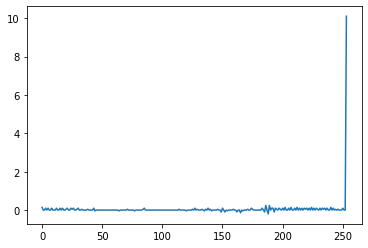

In [6]:
import matplotlib.pyplot as plt
# visualize the reward
plt.figure()
plt.plot(reward_hist)

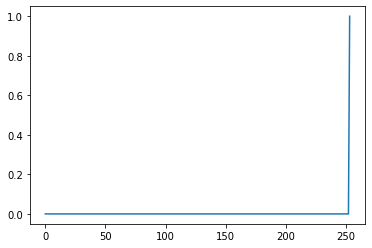

In [7]:
# visualize the done label
plt.figure()
plt.plot(done_hist)

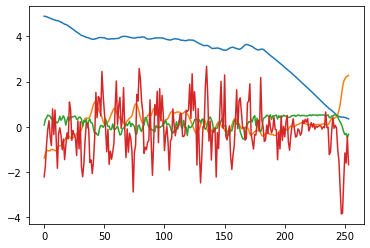

In [11]:
import matplotlib.pyplot as plt
# visualize the reward
plt.figure()
plt.plot([item['task_obs'] for item in state_hist])